# Results Summary

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS']

## Vision Models

### Behavior

In [37]:
files = glob(f'../data/interim/VisionBehaviorEncoding/*.csv.gz')
files.sort(key=os.path.getmtime)
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

In [38]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [39]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_3325061/3200536758.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


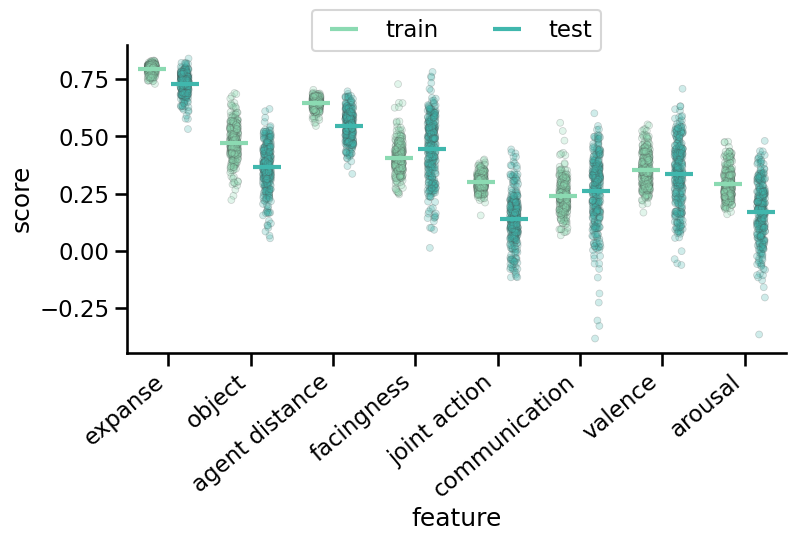

In [40]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)

### Neural

In [5]:
files = glob(f'../data/interim/VisionNeuralEncoding/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df).reset_index(drop=True)

217 neural encoding models found


100%|██████████| 217/217 [01:49<00:00,  1.98it/s]


,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index,layer_index,layer_relative_depth,layer,train_score,model_uid,test_score
0,108,pSTS,high_lateral,1,0.384594,4,30,36,128,0.255489,Linear-4-77,0.279401,timm_cait_xxs24_384,-0.058660
1,237,pSTS,high_lateral,1,0.580704,5,28,36,203,0.405190,Dropout-4-124,0.157740,timm_cait_xxs24_384,0.011109
2,238,pSTS,high_lateral,1,0.578962,5,28,37,379,0.756487,Mlp-3-119,0.243500,timm_cait_xxs24_384,-0.064154
3,239,pSTS,high_lateral,1,0.666494,5,28,38,16,0.031936,Identity-3-3,0.246997,timm_cait_xxs24_384,0.064284
4,244,pSTS,high_lateral,1,0.481124,5,29,36,63,0.125749,Identity-3-18,0.215069,timm_cait_xxs24_384,0.142499


In [6]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)
max_scores['normalized_score'] = max_scores['score'] / max_scores['reliability']

/tmp/ipykernel_3325061/974332269.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


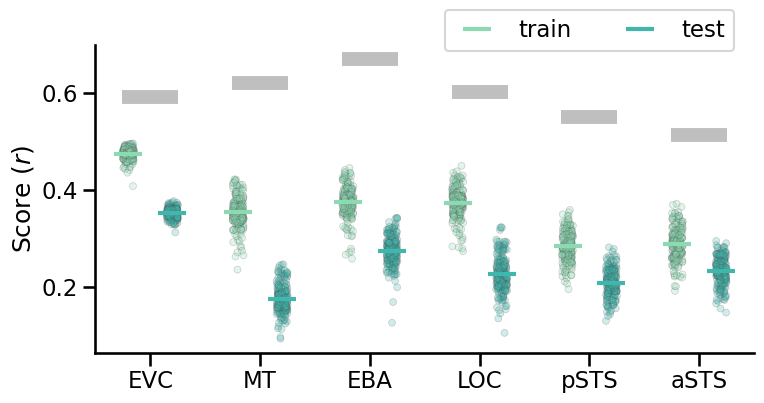

In [11]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
sns.pointplot(x='roi_name', y='reliability', data=max_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=50, markeredgewidth=10,
              alpha=.5, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15),
          ncol=3, fancybox=True)

/tmp/ipykernel_3325061/937176393.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


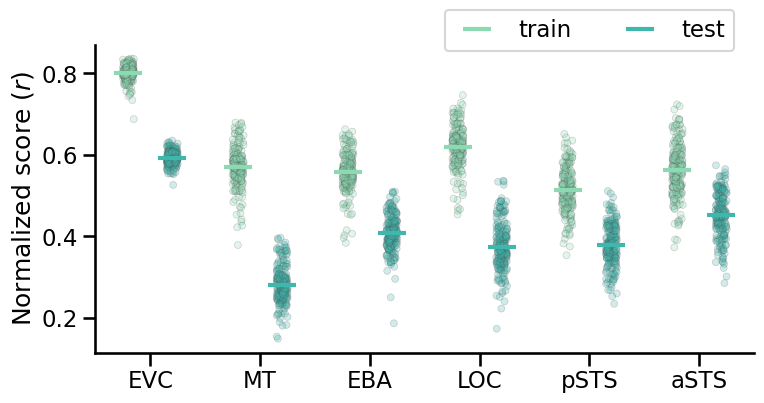

In [12]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Normalized score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15),
          ncol=3, fancybox=True)

/tmp/ipykernel_3325061/3175257575.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_scores_test_avg = max_scores_test.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_3325061/3175257575.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


(0.0, 1.0)

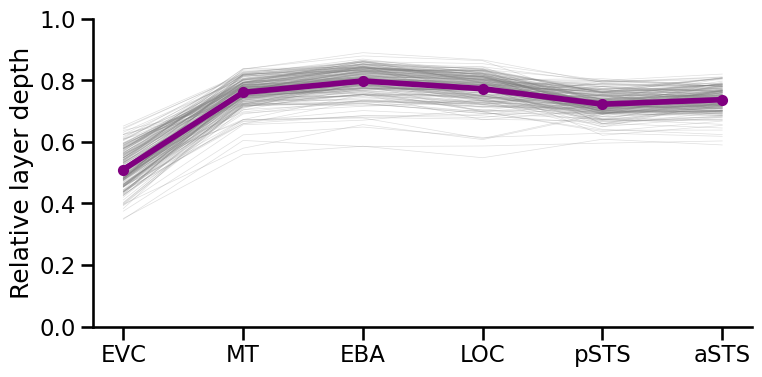

In [13]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}

max_scores_test = max_scores[max_scores.set == 'test'].reset_index(drop=True)
max_scores_test_avg = max_scores_test.groupby('roi_name').mean(numeric_only=True)

sns.pointplot(x='roi_name', y='layer_relative_depth', data=max_scores_test_avg,
             marker='.', markersize=10, zorder=1, color='purple')
sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid', data=max_scores_test,
              ax=ax, linewidth=.5, alpha=0.25, zorder=0, legend=False, palette=color_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Relative layer depth')
ax.set_ylim([0,1])

## Language Models

### Behavior

In [25]:
files = glob(f'../data/interim/LanguageBehaviorEncoding/*.csv.gz')
print(f'{len(files)} behavioral encoding models found')
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

2 behavioral encoding models found


In [26]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [27]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_3325061/3200536758.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


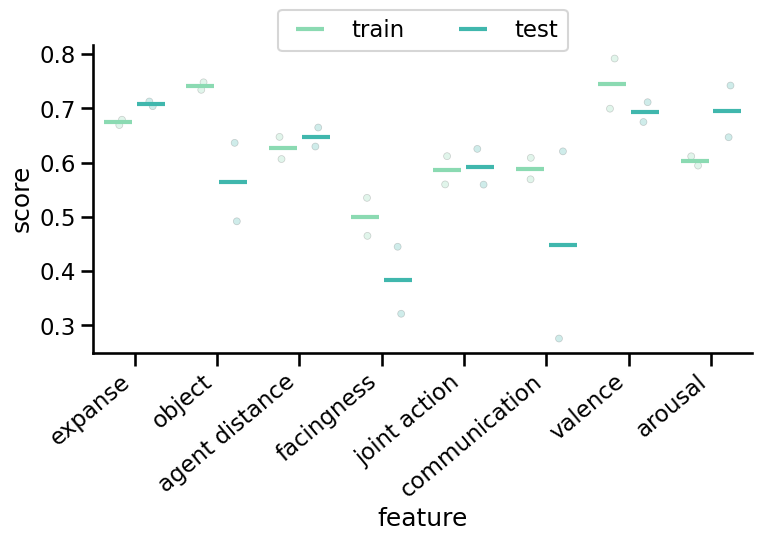

In [28]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)

### Neural

In [44]:
files = glob(f'../data/interim/LanguageNeuralEncoding/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df).reset_index(drop=True)

1 neural encoding models found


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


In [45]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)
max_scores['normalized_score'] = max_scores['score'] / max_scores['reliability']

/tmp/ipykernel_3325061/2291673528.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


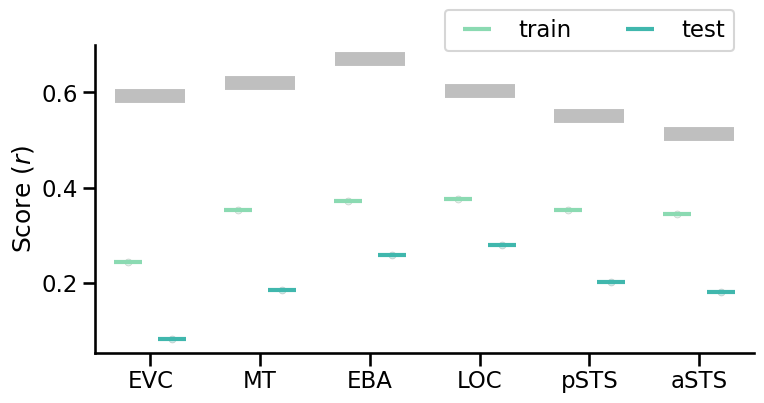

In [46]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
sns.pointplot(x='roi_name', y='reliability', data=max_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=50, markeredgewidth=10,
              alpha=.5, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15),
          ncol=3, fancybox=True)

/tmp/ipykernel_3325061/937176393.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


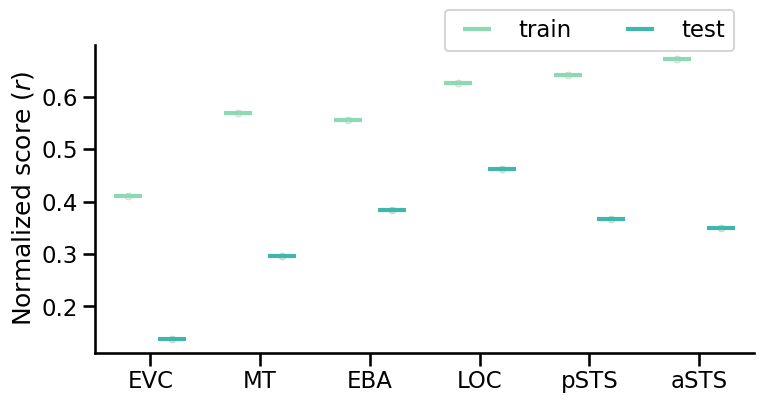

In [47]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Normalized score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15),
          ncol=3, fancybox=True)

/tmp/ipykernel_3325061/3175257575.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_scores_test_avg = max_scores_test.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_3325061/3175257575.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


(0.0, 1.0)

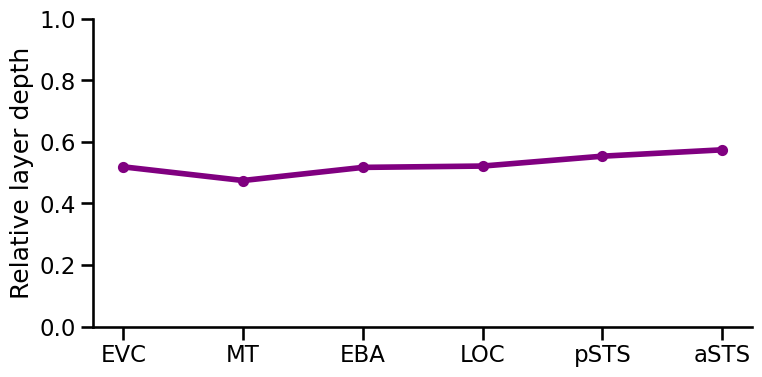

In [48]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}

max_scores_test = max_scores[max_scores.set == 'test'].reset_index(drop=True)
max_scores_test_avg = max_scores_test.groupby('roi_name').mean(numeric_only=True)

sns.pointplot(x='roi_name', y='layer_relative_depth', data=max_scores_test_avg,
             marker='.', markersize=10, zorder=1, color='purple')
sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid', data=max_scores_test,
              ax=ax, linewidth=.5, alpha=0.25, zorder=0, legend=False, palette=color_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Relative layer depth')
ax.set_ylim([0,1])

## Combined models

### Behavior

In [22]:
files = glob(f'../data/interim/VisionBehaviorEncoding/*.csv.gz')
files += glob(f'../data/interim/LanguageBehaviorEncoding/*.csv.gz')
print(f'{len(files)} behavior encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    if 'Vision' in file:
        cdf['model_class'] = 'vision'
    elif 'Language' in file:
        cdf['model_class'] = 'language'
    df.append(cdf)
df = pd.concat(df)
df.head()

338 behavior encoding models found


100%|██████████| 338/338 [00:01<00:00, 235.67it/s]


,model_uid,model_layer,model_layer_index,feature,train_score,test_score,model_class
0,timm_mvitv2_base,MultiScaleVit,1,rating-expanse,0.689438,0.640602,vision
1,timm_mvitv2_base,MultiScaleVit,1,rating-object,0.465206,0.150855,vision
2,timm_mvitv2_base,MultiScaleVit,1,rating-agent_distance,0.441004,0.405715,vision
3,timm_mvitv2_base,MultiScaleVit,1,rating-facingness,0.149872,-0.072921,vision
4,timm_mvitv2_base,MultiScaleVit,1,rating-joint_action,0.070612,0.031442,vision


In [23]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['model_class'] = pd.Categorical(max_scores['model_class'], categories=['vision', 'language'], ordered=True)
max_scores.head()

,model_uid,model_layer,model_layer_index,feature,train_score,test_score,model_class
0,bit_expert_abstraction,PreActBottleneck-3-15,155,agent distance,0.642042,0.578369,vision
1,bit_expert_animal,PreActBottleneck-3-15,155,agent distance,0.654780,0.602911,vision
2,bit_expert_arthropod,PreActBottleneck-3-15,155,agent distance,0.650945,0.592135,vision
3,bit_expert_bird,PreActBottleneck-3-15,155,agent distance,0.661486,0.594789,vision
4,bit_expert_flower,StdConv2d-4-142,168,agent distance,0.657495,0.531701,vision


/tmp/ipykernel_3325061/1820190713.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


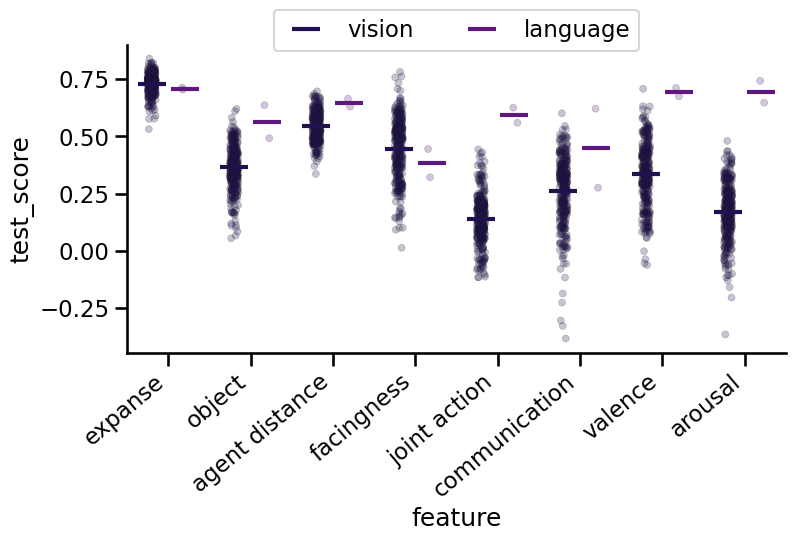

In [24]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='test_score', hue='model_class', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='test_score', hue='model_class', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)

### Neural

In [3]:
files = glob(f'../data/interim/VisionNeuralEncoding/*.csv.gz')
files += glob(f'../data/interim/LanguageNeuralEncoding/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    if 'Vision' in file:
        cdf['model_class'] = 'vision'
    elif 'Language' in file:
        cdf['model_class'] = 'language'
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df)
df['normalized_score'] = df['test_score'] / df['reliability']
df.head()

229 behavior encoding models found


100%|██████████| 229/229 [02:05<00:00,  1.83it/s]


,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index,layer_index,layer_relative_depth,layer,train_score,model_uid,test_score,model_class
0,108,pSTS,high_lateral,1,0.384594,4,30,36,128,0.255489,Linear-4-77,0.279401,timm_cait_xxs24_384,-0.058660,vision
1,237,pSTS,high_lateral,1,0.580704,5,28,36,203,0.405190,Dropout-4-124,0.157740,timm_cait_xxs24_384,0.011109,vision
2,238,pSTS,high_lateral,1,0.578962,5,28,37,379,0.756487,Mlp-3-119,0.243500,timm_cait_xxs24_384,-0.064154,vision
3,239,pSTS,high_lateral,1,0.666494,5,28,38,16,0.031936,Identity-3-3,0.246997,timm_cait_xxs24_384,0.064284,vision
4,244,pSTS,high_lateral,1,0.481124,5,29,36,63,0.125749,Identity-3-18,0.215069,timm_cait_xxs24_384,0.142499,vision


In [10]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)

max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['model_class'] = pd.Categorical(max_scores['model_class'], categories=['vision', 'language'], ordered=True)
max_scores.head()

/tmp/ipykernel_2612423/2740980668.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


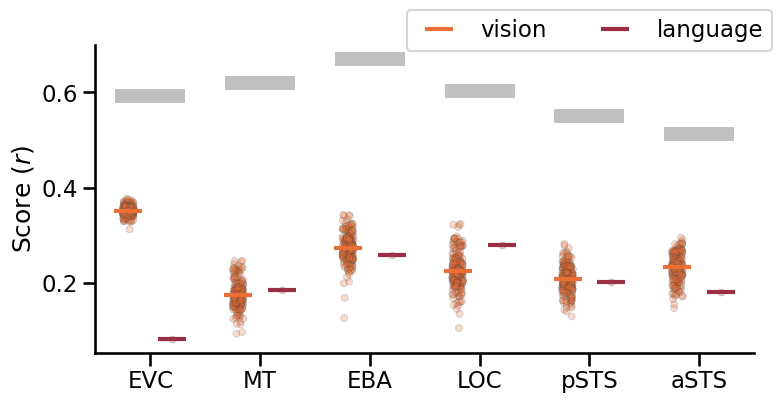

In [23]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='test_score', hue='model_class', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='test_score', hue='model_class', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
sns.pointplot(x='roi_name', y='reliability', data=max_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=50, markeredgewidth=10,
              alpha=.5, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15),
          ncol=3, fancybox=True)

/tmp/ipykernel_2612423/109200921.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')


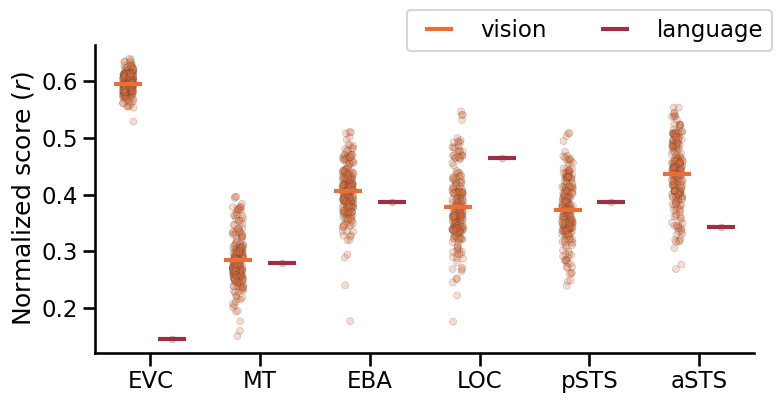

In [24]:
sns.set_context('talk', rc = {'patch.edgecolor': 'black', 'patch.force_edgecolor': True})
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='roi_name', y='normalized_score', hue='model_class', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='roi_name', y='normalized_score', hue='model_class', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha='center')
ax.set_xlabel('')
ax.set_ylabel('Normalized score ($r$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15),
          ncol=3, fancybox=True)